# Day 17

https://adventofcode.com/2022/day/17

In [26]:
def parse17(filename):
    with open(filename) as f:
        return f.read().strip()

In [387]:
from collections import defaultdict

def rocks(i,y):
    '''returns initial coordinated of each rock, given lowest y coordinate'''
    if i ==0:
        return ((2,y),(3,y),(4,y),(5,y)) # horizontal slab
    elif i==1:
        return ((2,y+1),(3,y),(3,y+1),(3,y+2),(4,y+1)) # cross
    elif i==2:
        return ((2,y),(3,y),(4,y),(4,y+1),(4,y+2)) # inverted L
    elif i==3:
        return ((2,y),(2,y+1),(2,y+2),(2,y+3)) # vertical slab
    elif i==4:
        return ((2,y),(2,y+1),(3,y),(3,y+1)) # square
    return []

def pushRock(rock,jet):
    rock_new = [ (x+1,y) if jet==">" else (x-1,y) for x,y in rock ]
    if rock_new[0][0]<0 or rock_new[-1][0]==7:
        return rock
    else:
        return rock_new

def collision(rock,space):
    for r in rock:
        if space[r]:
            return True
    return False

def dropRocks(jets,nrockmax=1,verbose=False):

    evolution = []
    
    space = defaultdict(int)
    
    # paint floor
    for x in range(7):
        space[(x,0)]=1

    ymax = 0
    ir = 0
    iw = 0
    nrocks = 0

    while True:

        # save info for part 2
        ir0 = str(ir)
        iw0 = ""
        x_rock = -1
        dy_rock = ymax+4
        dy_pile = ymax
        
        # generate rock
        rock = rocks(ir,ymax+4)
        nrocks += 1

        # move rock until rest
        while True:
            # 1. jet pushes rock avoiding walls 
            rock_push = pushRock(rock,jets[iw])
            iw0 += "_"+str(iw)
            iw = (iw+1)%len(jets) # next jet

            # 2. check whethere new position after push is possible
            if collision(rock_push,space):
                rock_push = rock

            # 3. try falling 1 unit
            rock_fall = [ (x,y-1) for x,y in rock_push ]
            if collision(rock_fall,space): # cannot fall to new position, stop in previous one
                for r in rock_push:
                    space[r] = 1
                # compute and save pile highest level
                ymax_rock = max([y for x,y in rock_push])
                if ymax_rock>ymax:
                    ymax = ymax_rock
                # store increase of rock pile height for part 2
                dy_pile = ymax - dy_pile
                # store x position for part 2
                x_rock = rock_push[0][0]
                # store delta y (drop) for part 2
                dy_rock -= rock_push[0][1]
                break
            else:
                rock = rock_fall

        # next rock
        ir = (ir+1)%5 
        
        # hash last rock status (rock index, first jet index, x landing position, dy fall)
        status = "{}_{}__{}__{}__{}".format(ir0,iw0,x_rock,dy_rock,dy_pile)
        if not nrockmax and status in evolution:
            if verbose:
                print("Found repeating configuration at rock",nrocks)
            evolution.append(status) # adding also repeating status to ease later calculation
            return space,ymax,evolution
        evolution.append(status)

        if nrockmax and nrocks==nrockmax:
            return space,ymax,evolution

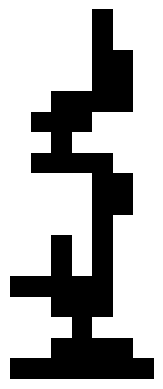

In [388]:
import matplotlib.pyplot as plt
import numpy as np

jets0 = parse17("examples/example17.txt")
space0_test,ymax0_test,_ = dropRocks(jets0,9)

spacetest = np.zeros((ymax0_test+1,7))
for (x,y),v in space0_test.items():
    if v:
        spacetest[y][x] = 1

plt.imshow(spacetest,origin='lower',cmap="binary")
_ = plt.axis('off')

In [389]:
space0,ymax0,_ = dropRocks(jets0,2022)
print("Test 1:",ymax0)

Test 1: 3068


In [390]:
jets = parse17("AOC2022inputs/input17.txt")
space,ymax,_ = dropRocks(jets,2022)
print("Part 1:",ymax)

Part 1: 3209


## Part 2

Clearly I cannot drop 1000000000000 rocks, I need to find a repetition of the rock configurations and compute the tower height from this information.

Information that could uniquely define a rock drop status and landing result:

- Rock index
- Jet indices
- Dropping height
- Landing position
- Increaase of rock pile height

I can apparently find a repetition...

The repeating rock cycle happens after an initial offset, so I will have to consider it to compute the full tower height, as well as any remainder:

In [391]:
def towerHeight(jets,N=2022,verbose=True):
    
    _,_,evo = dropRocks(jets,0,verbose)
    rep = evo[-1]
    beg = evo.index(rep)
    per = len(evo)-beg-1
    if verbose:
        print("Cycle begins at rock {} and has period {}".format(beg+1,per))

    _,h0,_ = dropRocks(jets,beg)
    _,h1,_ = dropRocks(jets,beg+per)
    h1 -= h0
    if verbose:
        print("Height offset ({} rocks) = {}".format(beg,h0))
        print("Height period ({} rocks) = {}".format(per,h1))

    Nper = (N-beg)//per
    rem = (N-beg)%per
    
    _,h2,_ = dropRocks(jets,beg+per+rem)
    h2 -= h0+h1
    
    if verbose:
        print("\nA tower of {} rocks is made of:".format(N))
        print("- 1 offset of {} rocks with height {}".format(beg,h0))
        print("- {} periods of {} rocks with height {}".format(Nper,per,h1))
        print("- 1 remainder of {} rocks with height {}".format(rem,h2))
    
    hN = h0 + Nper*h1 + h2
    if verbose:
        print("\nTower eight =",hN)
    return hN

In [392]:
towerHeight(jets0,N=2022) # 3068

Found repeating configuration at rock 51
Cycle begins at rock 16 and has period 35
Height offset (15 rocks) = 25
Height period (35 rocks) = 53

A tower of 2022 rocks is made of:
- 1 offset of 15 rocks with height 25
- 57 periods of 35 rocks with height 53
- 1 remainder of 12 rocks with height 22

Tower eight = 3068


3068

In [393]:
towerHeight(jets0,N=1_000_000_000_000) # 1514285714288

Found repeating configuration at rock 51
Cycle begins at rock 16 and has period 35
Height offset (15 rocks) = 25
Height period (35 rocks) = 53

A tower of 1000000000000 rocks is made of:
- 1 offset of 15 rocks with height 25
- 28571428571 periods of 35 rocks with height 53
- 1 remainder of 0 rocks with height 0

Tower eight = 1514285714288


1514285714288

In [394]:
towerHeight(jets,N=2022) # 3209

Found repeating configuration at rock 1748
Cycle begins at rock 23 and has period 1725
Height offset (22 rocks) = 38
Height period (1725 rocks) = 2744

A tower of 2022 rocks is made of:
- 1 offset of 22 rocks with height 38
- 1 periods of 1725 rocks with height 2744
- 1 remainder of 275 rocks with height 427

Tower eight = 3209


3209

In [381]:
towerHeight(jets,N=1_000_000_000_000) # 1590724637677 too high

Found repeating configuration at rock 1748
Cycle begins at rock 23 and has period 1725
Height offset (22 rocks) = 38
Height period (1725 rocks) = 2744

A tower of 1000000000000 rocks is made of:
- 1 offset of 22 rocks with height 38
- 579710144 periods of 1725 rocks with height 2744
- 1 remainder of 1578 rocks with height 2503

Tower eight = 1590724637677


1590724637677

In [412]:
towerHeight(jets,N=2*1725+22)

Found repeating configuration at rock 1748
Cycle begins at rock 23 and has period 1725
Height offset (22 rocks) = 38
Height period (1725 rocks) = 2744

A tower of 3472 rocks is made of:
- 1 offset of 22 rocks with height 38
- 2 periods of 1725 rocks with height 2744
- 1 remainder of 0 rocks with height 0

Tower eight = 5526


5526

In [413]:
# the height of the period is too large? Do I fail to intercept the correct period?

space,ymax,_ = dropRocks(jets,2*1725+22)
ymax

5514